# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"

In [2]:
DATA_DIR = 'data'
SAVE_DIR = "plots"

# The Problems

The problems we need to solve are:

Housing Price Prediction Problem. Suppose ‘Mr. X’ is planning to buy a house in Delhi and wants to predict the price of the house given some features like number of bedrooms, number of bathrooms, area of the house, etc. The file ’prob2data.csv’ contains a training set of housing prices in Delhi.

1. Read the excel file using `pandas` and perform data cleaning. Remove 1st column ’id’ which may not be necessary here. Perform mean normalization of features.
2. Write a Python code to perform multivariate regression to predict the house price. Consider all 5 columns (‘bedrooms’,...,‘yr built’) as features. Implement batch gradient descent for optimization of weights.
3. Predict the house price using the model, for 4 bedrooms, 2.5 bathrooms, 2570 sq. feet area, 2 floors, 2005 yr. built, and state the difference between the model prediction and actual value (Rs. 719000). Show in % error.

## The Approach

We'll be using `pandas` along with the `BatchGradientDescent` class which we have implemented in `GD.py` to solve the problem. For more details on how the class is implemented please see the notebook corresponding to the first problem.

### Formulation of the Problem

Here, we give a formal formulation of the problem.

The hypothesis function is:

$$
\hat{y} = h(\mathbf{w}, b) = h(\theta) =  \mathbf{w}^T \mathbf{x} + b
$$
with $\mathbf{w} = [w_1, w_2, w_3, w_4, w_5]$ are the weights and $\mathbf{x} = [x_1, x_2, x_3, x_4, x_5]$ are the input features.

For the loss function, we'll use the mean squared error loss function:

$$
J(\hat{y}, \mathbf{y}) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2
$$

We are using a factor of 2 instead of 1 to make the derivatives simpler.

The gradient descent algorithm is:

$$
\mathbf{w} := \mathbf{w} - \alpha \frac{\partial J}{\partial \mathbf{w}}\\
b := b - \alpha \frac{\partial J}{\partial b}
$$

Where $\alpha$ is the learning rate.

The partial derivatives can easily be calculated as:

$$
\frac{\partial J}{\partial \mathbf{w}} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) \mathbf{x}^{(i)}\\
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})
$$

We can include the bias term in the input features $\mathbf{x}$ by adding a column of 1's to the input features. This way, the partial derivatives calculated are the same while the update equations are simpler. We have:

$$
\mathbf{w} := \mathbf{w} - \alpha \frac{\partial J}{\partial \mathbf{w}}
$$

# Solving the Second Problem

## Problem 2.1

### Loading Data

In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, 'prob2data.csv'))
df.head()

,id,price,bedrooms,bathrooms,sqft_living,floors,yr_built
0,7129300520,221900.0,3,1.00,1180,1.0,1955
1,6414100192,538000.0,3,2.25,2570,2.0,1951
2,5631500400,180000.0,2,1.00,770,1.0,1933
3,2487200875,604000.0,4,3.00,1960,1.0,1965
4,1954400510,510000.0,3,2.00,1680,1.0,1987


Let's have a look at the dataframe.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           21613 non-null  int64  
 1   price        21613 non-null  float64
 2   bedrooms     21613 non-null  int64  
 3   bathrooms    21613 non-null  float64
 4   sqft_living  21613 non-null  int64  
 5   floors       21613 non-null  float64
 6   yr_built     21613 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 1.2 MB


So, there are not null values. Also, all the features are integres, so we don't need to do any conversion.

### Removing the ID Column

In [5]:
df.drop("id", axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,floors,yr_built
0,221900.0,3,1.00,1180,1.0,1955
1,538000.0,3,2.25,2570,2.0,1951
2,180000.0,2,1.00,770,1.0,1933
3,604000.0,4,3.00,1960,1.0,1965
4,510000.0,3,2.00,1680,1.0,1987


### Mean Normalization

Let's seperate the features and the target variable.

In [6]:
X = df.drop("price", axis=1).values
y = df["price"].values

In [7]:
col_means = X.mean()
col_maxes = X.max()
col_mins = X.min()

X = (X - col_means) / (col_maxes - col_mins)

## Problem 2.2

We will be using the code written previously to erform multivariate regression to predict the house price. Please see the notebook for problem 1 for more detail.

We will use the `BatchGradientDescent` class.

Let's create the $X$ feature matrix and $\mathbf{y}$ target vector.

We'll be doing train test split (no dev set) to gauge the performance of the model.

In [10]:
np.random.seed(42)
ratio = 0.8
ids = np.arange(X.shape[0])
np.random.shuffle(ids)
train_ids = ids[:int(ratio * X.shape[0])]
test_ids = ids[int(ratio * X.shape[0]):]
X_train, y_train = X[train_ids], y[train_ids]
X_test, y_test = X[test_ids], y[test_ids]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17290, 5), (4323, 5), (17290,), (4323,))

In [11]:
X_train.max(), X_train.min()

(0.9400607861153099, -0.059939213884690146)

While training, we'll use the `tol` feature of the `BatchGradientDescent`. We'll stop training if the `tol` becomes less than $10^{-6}$.

In [12]:
from GD import BatchGradientDescent
bgd = BatchGradientDescent(tol=1e-6)

In [13]:
np.random.seed(42)
bgd.fit(X_train, y_train, learning_rate=0.1, epochs=10000, verbose=0)

Converged at epoch 7458     ] 74.6%
Loss: 35262808669.764084


Let's see what is the mean error made by the model.

In [14]:
y_pred_train = bgd.predict(X_train)
y_pred_test = bgd.predict(X_test)
rmse_train = np.sqrt(np.sum(((y_pred_train - y_train)**2))/len(y_train))
rmse_test = np.sqrt(np.sum(((y_pred_test - y_test)**2))/len(y_test))
print(f"Train RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")

Train RMSE: 265566.4642507701
Test RMSE: 245161.23828483588


In [15]:
print(y.mean())

540182.1587933188


The model is performing good enough. Considering the fact that it assumes a linear relationship between the features and the target variable, it is doing a good job.

Let's also plot the loss with epochs.

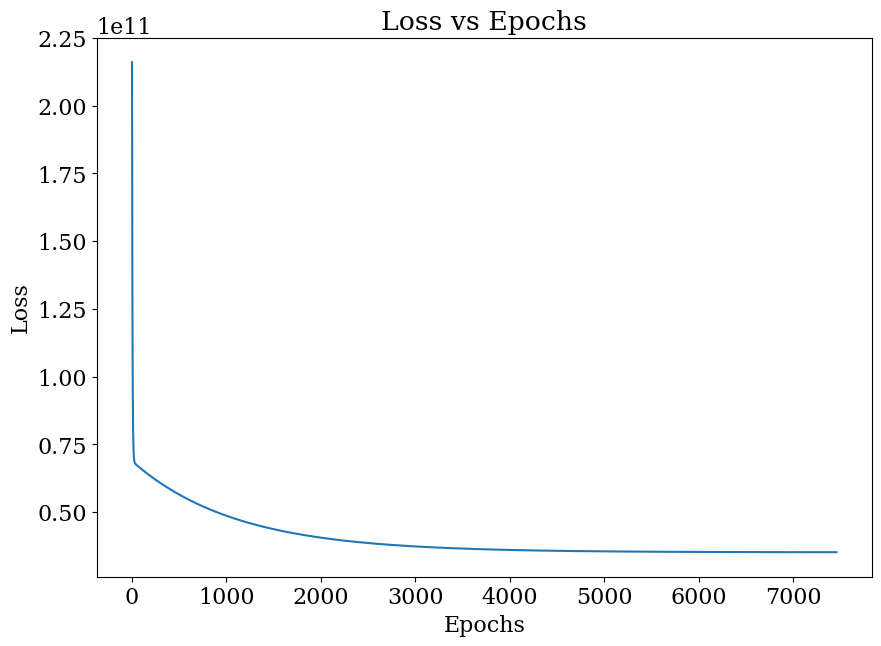

In [16]:
fig, ax = plt.subplots()

epochs = np.arange(1, len(bgd._losses)+1)
ax.plot(epochs, bgd._losses)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
plt.savefig(os.path.join(SAVE_DIR, "0201.png"));

We can see that the loss is not decreasing that much after epoch 1000 or so.

## Problem 2.3

Let's create a vector with the given features:

In [17]:
example = np.array([4, 1.5, 2570, 2, 2005]).reshape(1,-1)
example = (example - col_means) / (col_maxes - col_mins)

In [18]:
example_pred = bgd.predict(example)
correct_price = np.array([719000])
absolute_error = np.abs(correct_price - example_pred)
percentange_error = 100*absolute_error/correct_price

print(f"Correct Price: {correct_price[0]} => Predicted Price: {example_pred[0]:.0f}")
print(f"Absolute Error: {absolute_error[0]:.0f}")
print(f"Percentage Error: {percentange_error[0]:.2f}%")

Correct Price: 719000 => Predicted Price: 675790
Absolute Error: 43210
Percentage Error: 6.01%


So, the model gives about 6% error.